La [regresión logística](https://en.wikipedia.org/wiki/Logistic_regression) es similar a la [regresión lineal](https://www.google.com/search?q=/blog/ml-linear-regression/), pero en lugar de predecir una salida continua, clasifica los ejemplos de entrenamiento mediante un conjunto de categorías o etiquetas. Por ejemplo, la regresión lineal en un conjunto de datos sociales y económicos podría utilizarse para predecir los ingresos de una persona, pero la regresión logística podría utilizarse para predecir si esa persona está casada, tiene hijos o ha sido arrestada alguna vez. En un sentido básico, la regresión logística solo responde a preguntas que tienen respuestas de sí/no, o preguntas que pueden responderse con un 1 o un 0. Sin embargo, puede [extenderse](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) fácilmente a problemas en los que existe un conjunto mayor de categorías.

Aquí, estoy utilizando el conjunto de datos [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) (Vino) de la UCI. Este asigna trece variables continuas, que representan el contenido químico de un vino, a tres etiquetas; cada una corresponde a una bodega diferente en Italia.

# Carga y Graficado de Datos

Inicialmente, solo estoy utilizando dos características (*features*) del conjunto de datos: alcohol y ceniza. Las etiquetas se proporcionan como un arreglo de datos con valores del `1` al `3`, pero al principio, solo quiero un problema de regresión simple con una respuesta de sí o no.

Para ello, primero filtro el conjunto de datos, reduciéndolo para incluir únicamente vinos con las etiquetas `1` o `2`. A continuación, utilizo la función `label_binarize` de scikit-learn, que toma una lista de longitud $m$ con $n$ valores posibles (dos, en este caso) y la convierte en una matriz de $m \times n$, donde cada columna representa una etiqueta con valor `1` y todas las demás con valor `0`. Elijo la primera columna, aunque la segunda sería igualmente válida aquí, simplemente con las etiquetas invertidas.

A continuación, he incluido un pequeño ejemplo de `label_binarize`, mezclando primero todo el conjunto de datos de entrada (los ejemplos están ordenados por bodega) y seleccionando después los diez primeros.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
#X = reduced.as_matrix(columns=['alcohol', 'ash'])
X = reduced[['alcohol', 'ash']].values
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]

example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, classes=list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [1 1 2 2 3 1 3 3 3 3]
binarized: [[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
1s vs all: [1 1 0 0 0 1 0 0 0 0]


I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

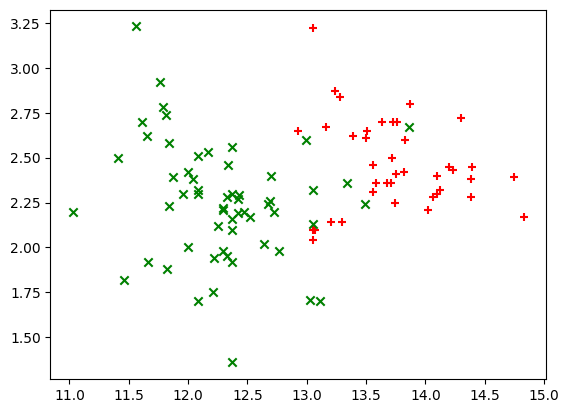

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

Hay una zona bastante obvia cerca del centro del gráfico donde una línea podría dividir los dos colores de puntos con un pequeño margen de error.

# Regresión Logística Simple

Para implementar la regresión logística, necesito una función de hipótesis $h_\theta(x)$, una función de costo $J(\theta)$ y una función de gradiente que calcule las derivadas parciales de $J(\theta)$.

En la regresión logística, $h_\theta$ es la función [sigmoide](https://www.quora.com/Logistic-Regression-Why-sigmoid-function). La función sigmoide está acotada entre 0 y 1, y produce un valor que puede interpretarse como una probabilidad. Este valor también puede ser una respuesta de sí/no con un punto de cruce, o frontera de decisión (*decision boundary*), en 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Usar el [error cuadrático medio](https://en.wikipedia.org/wiki/Mean_squared_error) de la regresión lineal no es una buena idea aquí, ya que la función de costo resultante [no es convexa](http://mathworld.wolfram.com/SigmoidFunction.html) y, por lo tanto, no es adecuada para el descenso de gradiente. En su lugar, la diferencia de $h_\theta(x^i) - y^i$ se calcula de manera diferente para $y=0$ y $y=1$, y el resultado se [transforma](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarítmicamente](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) en una función convexa:

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Afortunadamente, la [derivada](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) de esta función es exactamente la misma que la de la regresión lineal, solo que con un $h_\theta(x)$ diferente:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [ ]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [ ]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [72.1250648  -4.96387368 -3.0874307 ]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   1.66077692E-03
tnc: fscale = 24.5383
    1    3  6.931065735846907E-01   1.90691853E-03
tnc: stepmx = 1000
    2    5  4.818389882982752E-01   3.13788964E-03
    3    7  4.543669236870654E-01   1.52265554E+00
tnc: fscale = 0.8104
    4    9  4.336859328255182E-01   6.76050832E-04
tnc: fscale = 38.4601
    5   11  4.336202493661249E-01   4.14978604E-03
    6   13  3.786646260004704E-01   1.67643644E-02
    7   15  3.748442974755624E-01   1.26230687E-01
    8   17  3.611386429502178E-01   2.17941505E-02
    9   19  3.598884445396887E-01   9.48251629E-03
   10   21  3.584725846582344E-01   1.18265182E-01
   11   26  2.943727965853128E-01   3.76119937E-02
   12   28  2.933350987219769E-01   2.94549894E-03
   13   32  2.767151032028906E-01   4.33598441E-02
   14   34  2.758293804756853E-01   2.24191077E-03
   15   36  2.705420926542681E-01   6.13131916E-03
   16   38  2.701798361150627E-01   2.80828375E-03
   17   

# Fronteras de Decisión y Evaluación

Puedo evaluar los resultados de la optimización tanto visual como estadísticamente, pero también necesito una función más: `predict`, la cual toma como entradas un arreglo de ejemplos `X` y los valores de los parámetros aprendidos `theta`, y devuelve la etiqueta predicha para cada uno. Aquí también se deben anteponer unos (1s) a las entradas, y devuelvo un valor entero que representa si el resultado de la función de hipótesis `sigmoid` es mayor o igual a 0.5.

Para probar los resultados de esas predicciones, Scikit-learn proporciona tres funciones para calcular la [exactitud, precisión y recuperación](https://en.wikipedia.org/wiki/Precision_and_recall) (*accuracy, precision and recall*). Aquí se utilizan los datos de prueba anteriores, por lo que los resultados representan el rendimiento del clasificador con datos no vistos (*unseen data*).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)
predictions = np.asarray(predictions).flatten()
print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9090909090909091
precision: 0.9107142857142857
recall: 0.898076923076923


* La función predict(X, theta)
Esta función toma las características de prueba (X) y los parámetros aprendidos (theta) para generar una etiqueta (1 o 0).

El código compara las predicciones del modelo contra las respuestas reales (y_test) usando tres métricas clave:

Accuracy (Exactitud):

* accuracy_score(y_test, predictions)
Mide el porcentaje total de aciertos. Responde a: "¿De todos los casos, cuántos clasificó correctamente el modelo?".

* Precision (Precisión):
precision_score(..., average='macro')
Mide la calidad de los positivos. Responde a: "De todos los que el modelo dijo que eran positivos (1), ¿cuántos eran realmente positivos?".

El parámetro average='macro' calcula la métrica para cada etiqueta y encuentra su media no ponderada (útil si hubiera desbalance de clases, aunque aquí es binario).

* Recall (Recuperación o Sensibilidad):
recall_score(..., average='macro')
Mide la cantidad de positivos reales encontrados. Responde a: "De todos los que realmente eran positivos en la vida real, ¿cuántos logró encontrar el modelo?".

Es mucho más interesante revisar los resultados visualmente, al menos mientras el número de características (*features*) está limitado a dos. Para hacer esto, necesito graficar nuevamente los puntos de entrada y luego superponer la frontera de decisión (*decision boundary*). Probé varios enfoques para esto en Matplotlib y descubrí que un gráfico de contorno sin relleno (*unfilled contour plot*) me daba los mejores resultados. Esto también se puede hacer calculando manualmente la función a graficar, o utilizando un gráfico de contorno relleno que sombrea las áreas reales, pero hacer los cálculos a mano es tedioso y los mapas de color para los gráficos de contorno relleno dejan mucho que desear visualmente.

A continuación, defino una función `plot_boundary` que toma una matriz de $n \times 2$ de valores de características $(x_0, x_1)$ y una función de predicción; luego, construye una malla (*mesh grid*) de puntos $(x, y)$ correspondientes a los posibles valores de $(x_0, x_1)$ dentro del rango de entrada. Tras ejecutar la función de predicción en todos ellos, el resultado es un punto $(x, y, z)$ en el espacio. Debido a que el resultado no es continuo y cambia directamente de 0 a 1, solo hay un contorno que se puede dibujar en el gráfico: la frontera de decisión.

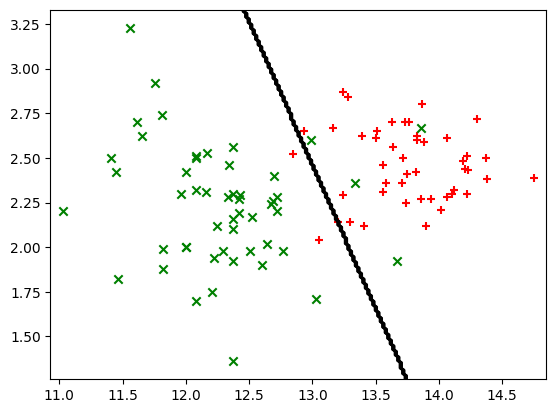

In [ ]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')# dibuja la frontera de decisión
        
plot_points(X_train, y_train) # dibuja los puntos de entrenamiento
plot_boundary(X_train, lambda x: predict(x, theta)) # dibuja la frontera de decisión

Primero dibuja tus puntos de datos originales.

Luego llama a la función que acabamos de definir.

Nota sobre lambda: plot_boundary espera una función simple pred(x), pero nuestra función predict necesita dos cosas (x y theta). Usamos lambda (una función anónima) para "envolver" nuestra predicción y pasarle el theta fijo que ya calculamos, de modo que plot_boundary solo tenga que preocuparse por la x.